# Quaternion convolutional layers reproduction

Firstly I want to check if it possible to recreate the paper. This process will consist of the following steps

- Dataloader
- DataFormatter
- QCNN import 
- QNN import
- Recreate archtitecture 
- Train

# Questions for the following session

- Where does the conversion to quaternions happen
- When we input the output feautures map into the Qlinearlayer we lose all our information right
- Why do de images needed te be padded with a extra dimension

# To do following session

- Train the network

## Modules


In [5]:
import numpy as np
import torch as th
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import core_qnn as qcnn
import torch
import torch.nn as nn
from   torch.nn import Parameter
from   torch.nn import functional as F
import torch.optim
from   torch.autograd import Variable
from   torch import autograd
import os
import pickle
import numpy as np

## Dataloader

In [6]:
# Tranform data to PyTorch tensore
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

# Download the data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

# Define the loaders
train_loader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_testset, batch_size=1000)

# Here we can add some data cleanup

Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([64, 3, 32, 32])


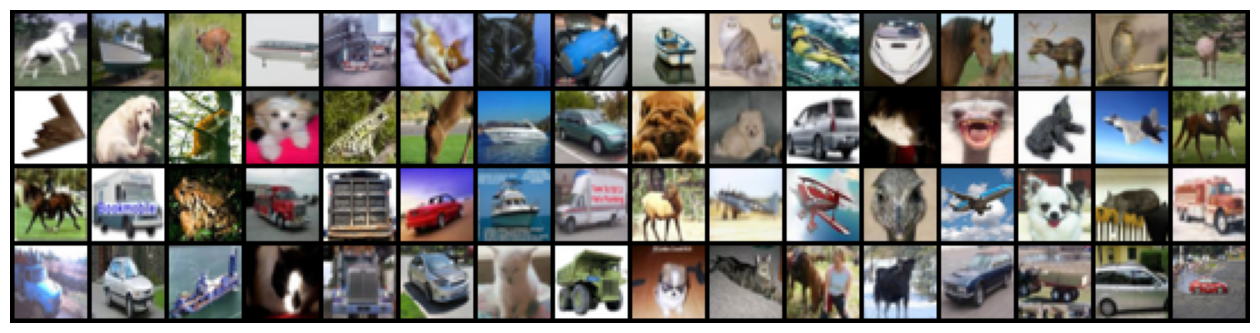

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

This is the size of image data torch.Size([64, 3, 32, 32])
This is the size of labels data torch.Size([64])


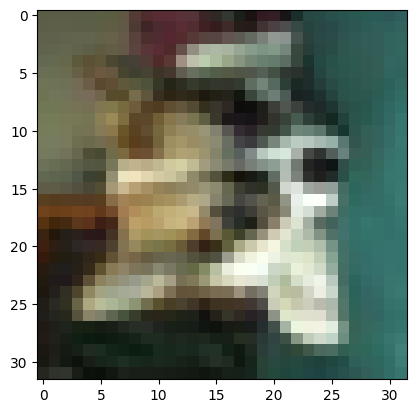

In [18]:
iter_func = iter(train_loader)

image_data, label_data = next(iter_func)

print("This is the size of image data",image_data.shape)

print("This is the size of labels data",label_data.shape)

plt.imshow(image_data[1].permute((2,1,0)).numpy().squeeze(), cmap='Greys_r')

In [42]:
import pickle
import numpy as np

batch_size = 32
num_classes = 10
epochs = 30
data_augmentation = True
num_predictions = 20


x_train = torch.cat([batch[0] for batch in train_loader], dim=0).cuda()
y_train = torch.cat([batch[1] for batch in train_loader], dim=0).cuda()

x_test = torch.cat([batch[0] for batch in test_loader], dim=0).cuda()
y_test = torch.cat([batch[1] for batch in test_loader], dim=0).cuda()

y_train = torch.nn.functional.one_hot(y_train, num_classes).cuda()
y_test = torch.nn.functional.one_hot(y_test, num_classes).cuda()

# We must add the zero dimension
x_train /= 255
x_test /= 255
#add an extra dim with 0s
x_train = torch.cat([x_train, torch.zeros(50000, 1, 32, 32).cuda()], dim=1)

## Creating the model

In [169]:
from   core_qnn.quaternion_layers import QuaternionLinear, QuaternionTransposeConv, QuaternionConv



class SimpleModule(nn.Module):
    
    def __init__(self):
        super(SimpleModule, self).__init__()
        
        self.layer1 = QuaternionConv(in_channels=4, out_channels=4, kernel_size = 3, stride = 1, padding = 1)
        self.layer2 = nn.Linear(4096, 516)
        self.layer3 = nn.Linear(516, 10)

    def forward(self, x):
        x = self.layer1.forward(x)
        x = F.relu(x)
        x = th.flatten(x)
        x = self.layer2.forward(x)
        x = F.relu(x)
        x = self.layer3.forward(x)
        x = F.softmax(x)

        return x
    
    def name(self):
        return "SimpleModule"
    
class TheModule(nn.Module):
    
    def __init__(self):
        super(TheModule, self).__init__()
        
        self.layer1 = QuaternionConv(in_channels=4, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
        self.layer2 = QuaternionConv(in_channels=32, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
        self.layer3 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.layer4 = nn.Dropout(0.25)

        self.layer5 = QuaternionConv(in_channels=32, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.layer6 = QuaternionConv(in_channels=64, out_channels=64, kernel_size = 3, stride = 1, padding = 1)

        self.layer7 = QuaternionLinear(4096, 512)
        self.layer8 = nn.Linear(512, 10)
        self.layer9 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1.forward(x)
        x = F.relu(x)
        x = self.layer2.forward(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.layer5.forward(x)
        x = F.relu(x)
        x = self.layer6.forward(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        flat = nn.Flatten()
        x = flat(x)
        
        x = self.layer7.forward(x)
        x = F.relu(x)
        x = self.layer8.forward(x)
        x = self.layer9(x)
        x = th.sigmoid(x)

        return x
    
    def name(self):
        return "SimpleModule"
    




## Training the network 


In [170]:
model = SimpleModule().cuda()
modeltwo = TheModule().cuda()

In [102]:
x_train[:2].shape

torch.Size([2, 4, 32, 32])

In [149]:
model.forward(x_train[:1])


C:\Users\31642\AppData\Local\Temp\ipykernel_36168\3473538896.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


tensor([0.1013, 0.0977, 0.0996, 0.0986, 0.1022, 0.1023, 0.0985, 0.1009, 0.0977,
        0.1010], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [164]:
modeltwo.forward(x_train[:1])

tensor([[0.4893, 0.5000, 0.5000, 0.4799, 0.5000, 0.5000, 0.4906, 0.5000, 0.4785,
         0.5180]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [168]:
criterion = nn.CrossEntropyLoss()

opt = torch.optim.RMSprop(model.parameters(), lr = 0.0001)

#  My simple module requires batch size to be 1
BATCH_SIZE = 32
SAMPLES = 50000

# Choose your model
if True: model = SimpleModule().cuda(); BATCH_SIZE = 1
if False: model = TheModule().cuda(); BATCH_SIZE = 32

num_epochs =  30
for epoch in range(num_epochs):
    

    
    # Let's create an batch
    for i in  range(int(SAMPLES/BATCH_SIZE)):
        opt.zero_grad()


        x_train_batch = x_train[i *BATCH_SIZE : BATCH_SIZE*(i + 1 )]
        y_train_batch = y_train[i *BATCH_SIZE : BATCH_SIZE*(i + 1 )].to(torch.float)
      
        # Forward pass
        outputs = modeltwo(x_train_batch)
        

        loss = criterion(outputs.view(-1), y_train_batch.view(-1))
        # Backward and optimize
        print(loss)
        
        loss.backward()
        opt.step()

    # Print progress
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'
               .format(epoch+1, num_epochs, loss.cpu().item()))

tensor(184.5976, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5675, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5585, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.4886, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5387, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5647, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.6330, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.6393, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.6156, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5431, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5394, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.6069, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.7276, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.6615, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5305, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.6414, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.5862, device='cuda:0', grad_fn=<DivBackward1>)
tensor(184.582

KeyboardInterrupt: 

In [ ]:
one = QuaternionConv(in_channels=4, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
relu = nn.ReLU()
two =    QuaternionConv(in_channels=32, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
max1 = nn.MaxPool2d(kernel_size=2, stride = 2, padding = 0)

three = QuaternionConv(in_channels=32, out_channels=64, kernel_size = 3, stride = 1, padding = 1)

four = QuaternionConv(in_channels=64, out_channels=64, kernel_size = 3, stride = 1, padding = 1)



print(one.forward(x_train_batch).shape)
print(relu(one.forward(x_train_batch)).shape)
print(two.forward(relu(one.forward(x_train_batch))).shape)
print(relu(two.forward(relu(one.forward(x_train_batch)))).shape)
print(max1(relu(two.forward(relu(one.forward(x_train_batch))))).shape)

out1 = max1(relu(two.forward(relu(one.forward(x_train_batch)))))
print(" ")
print(three.forward(out1).shape)
print(relu(three.forward(out1)).shape)
print(four.forward(relu(three.forward(out1))).shape)
print(relu(four.forward(relu(three.forward(out1)))).shape)
print(max1(relu(four.forward(relu(three.forward(out1))))).shape)